# Overcomplete ICA demo


* Independent Components Analysis (ICA) is a technique to generate <b> linear models </b> of a given data set.

* The goal of ICA is to learn a <b> set of features </b> that can be linearly combined to explain the data. 

* <b> Overcomplete </b> simply means that the number of features is larger than the number of dimensions of the data (e.g., the number of pixels in an image). You can think of a room with 3 microphones and you are trying to recover the voices generated by 5 different speakers. 




## We start by importing some librabries


For this demo, we use NumPy, Matplotlib and Scikit-Learn. Theano will be used for performing overcomplete ICA, but this library is loaded when importing the ica module so we don't need to import it directly here.  

In [23]:
from __future__ import division
import numpy as np
from numpy.linalg import svd,norm
from scipy.io import loadmat
from sklearn.feature_extraction import image
from sklearn.decomposition import FastICA

#my modules
import ica as ocica 
from utils import tile_raster_images as tri
from visualizations import *
import visualizations as vz

import matplotlib as mpl
import matplotlib.pyplot as plt

# Setting some default plotting parameters
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'gray'
mpl.rcParams['figure.figsize'] = (6, 6)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize']  = 20
mpl.rcParams['legend.fontsize'] = 20

# Enable inline plotting
%matplotlib inline

## and loading the data set

The dataset is composed by 10 black and white images.  

In [2]:
images = loadmat('IMAGES_RAW.mat')['IMAGESr']

We performa a visual inspection of the dataset. Here, we just plot one image.

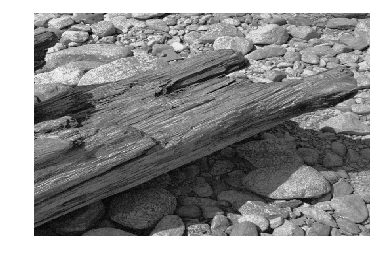

In [5]:
plt.imshow(images[...,0])
plt.gca().set_axis_off()
plt.show()

## Extracting image patches

It is not advisable to train ICA models using full images because it would be too expensive computationally. 

Instead, we use 8-by-8 pixel image patches to train the models. 

In [20]:
n_dimensions = 64                      # Total number of pixels
im_size = int(np.sqrt(n_dimensions))   # Size of the image patches in pixels
total_samples = 16000                  # Number of samples 
rng = np.random.RandomState(1234)      # Initializes the pseudo-random number generator 

We use Scikit-learn's PatchExtractor function from the image module to generate random patches from the dataset.  

In [9]:
patches = image.PatchExtractor(patch_size=(im_size, im_size),\
                               max_patches=total_samples//images.shape[-1],
                               random_state=rng).transform(images.T)
X = patches.reshape((total_samples,n_dimensions)).T

# Preprocessing the data 

Before we train our ICA models some additional pre-processing steps are necessary. 

## 1) Centering the data

In [10]:
X_mean = X.mean(axis=-1, keepdims=True)
X -= X_mean

## 2) Whitening 

Whitening removes second order correlations, which helps ICA algorithms remove the remaining (higher-order) dependencies.

Whitening can be done using the singular value decomposition method (SVD).

In [12]:
u, d, _ = svd(X, full_matrices=False)
del _
# K is the so-called whitening matrix
K = (u/d).conj().T
del u,d
# We use the whitening matrix to project the data
X_pca = K.dot(X)
X_pca*=np.sqrt(total_samples)

# Learning ICA models of natural images

## Complete ICA

In complete ICA the number of features that we want to extract is the equivalent to the number of dimensions in the data, in this case 64 pixels. 

This analysis can be done using the Python library <b> Scikit-learn </b>. 

We compare our custom Theano implementation with the Scikit-learn version.   

In [15]:
# using our Theano implementation
theano_ica = ocica.ICA(n_mixtures=n_dimensions,n_sources=n_dimensions,lambd=.1,
                       degeneracy='L2',optimizer='L-BFGS-B')
theano_ica.fit(X_pca)

# using Scikit-learn fast ICA algorithm
sklearn_ica = FastICA(n_components=n_dimensions,whiten=False)
sklearn_ica.fit(X_pca.T)

Random seed: 29316
Degeneracy control: L2
Loss: 21.4569282532, Error: 19.3612251282, Penalty: 20.9570331573, MSE: 0.417192161083
Loss: 10.8901138306, Error: 8.79430580139, Penalty: 20.9580821991, MSE: 0.225098580122
Loss: 7.3846411705, Error: 5.28879261017, Penalty: 20.9584846497, MSE: 0.144335120916
Loss: 5.23963451385, Error: 3.14455127716, Penalty: 20.9508342743, MSE: 0.089708968997
Loss: 3.78326749802, Error: 1.68845534325, Penalty: 20.9481201172, MSE: 0.050006121397
Loss: 3.03565120697, Error: 0.941405177116, Penalty: 20.9424591064, MSE: 0.0274804402143
Loss: 2.67344880104, Error: 0.579065561295, Penalty: 20.9438323975, MSE: 0.0170324612409
Loss: 2.29136514664, Error: 0.197109490633, Penalty: 20.9425563812, MSE: 0.00573464436457
Loss: 2.13886404037, Error: 0.0447768755257, Penalty: 20.9408721924, MSE: 0.0013297443511
Loss: 2.10308837891, Error: 0.00905743800104, Penalty: 20.9403095245, MSE: 0.000279363943264
Loss: 2.09549450874, Error: 0.00151848467067, Penalty: 20.9397602081, MSE

/home/redwood/anaconda/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:290: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn('Ignoring n_components with whiten=False.')


FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=64, random_state=None, tol=0.0001, w_init=None,
    whiten=False)

We can now extract the features learned with both algorithms. We project the features into pixel space using the whitening matrix K. 

In [16]:
theano_features = theano_ica.components_.dot(K)
sklearn_features = sklearn_ica.components_.dot(K)

We use a plot function to visualize the learned features.

In [17]:
def plot_bases(bases,figsize=None):
    """Plots a basis set
    
    Parameters:
    ----------
    bases : array
           Set of basis.
           Dimension: n_costs X n_vectors X n_dims
    figname: string, optional
           Name of the figure
    """
    n_pixels = int(np.sqrt(bases.shape[1]))
    n_bases  = int(np.sqrt(bases.shape[0]))
    if figsize is None:
        fig = plt.figure()
    else:
        fig = plt.figure(figsize=figsize)
    fig.clf()
    ax = plt.axes()
    im = tri(bases,(n_pixels,n_pixels),(n_bases,n_bases),
                (2,2), scale_rows_to_unit_interval=False,
                output_pixel_vals=False)
    ax.imshow(im)
    ax.set_axis_off()
    plt.show()

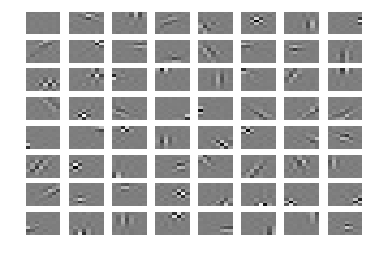

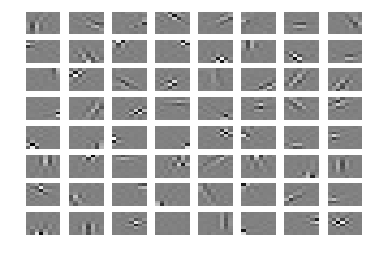

In [18]:
plot_bases(theano_features)
plot_bases(sklearn_features)

The features learned by both algorithms are qualitatively similar. In the case of natural images, it is expected to learn different features every time. In fact, the number of features that originates natural images is thought to be infinite!

It seems that we could do better if we can learn more features!

## Overcomplete ICA

Next, we learn an overcomplete ICA model. Scikit-learn still does not support overcomplete ICA. In fact, the most coommonly used ICA algorithms cannot be extended to the overcomplete case. 

In [21]:
overcompleteness = 4                                  # level of overcompleteness
n_features = n_dimensions*overcompleteness
overcomplete_ica = ocica.ICA(n_mixtures=n_dimensions,n_sources=n_features,lambd=1.,
                            degeneracy='L2',optimizer='L-BFGS-B')
overcomplete_ica.fit(X_pca)

Random seed: 52921
Overcomplete ICA
Degeneracy control: L2
Loss: 538.594055176, Error: 454.751342773, Penalty: 83.8427352905, MSE: 0.121203757823
Loss: 470.662658691, Error: 386.901641846, Penalty: 83.7610092163, MSE: 0.00545823993161
Loss: 467.950164795, Error: 384.188415527, Penalty: 83.7617416382, MSE: 0.000380042329198
Loss: 467.775909424, Error: 384.018096924, Penalty: 83.7578201294, MSE: 4.85724085593e-05
Loss: 467.760101318, Error: 384.007965088, Penalty: 83.7521286011, MSE: 2.78884963336e-05
Loss: 467.75201416, Error: 384.008544922, Penalty: 83.7434616089, MSE: 2.83176050289e-05
Loss: 467.731414795, Error: 384.017456055, Penalty: 83.7139511108, MSE: 4.45721161668e-05
Loss: 467.67880249, Error: 384.052124023, Penalty: 83.6266784668, MSE: 0.000109957632958
Loss: 467.543334961, Error: 384.166290283, Penalty: 83.3770370483, MSE: 0.000327754940372
Loss: 467.339324951, Error: 384.454345703, Penalty: 82.8849868774, MSE: 0.000872589356732
Loss: 466.990997314, Error: 384.324157715, Pena

ICA(a=None, degeneracy=None, lambd=None, learning_rule=None, n_mixtures=64,
  n_sources=256, optimizer=<optimizers.LBFGSB object at 0x7fd956837c90>,
  p=None, rng=None, w_init=None)

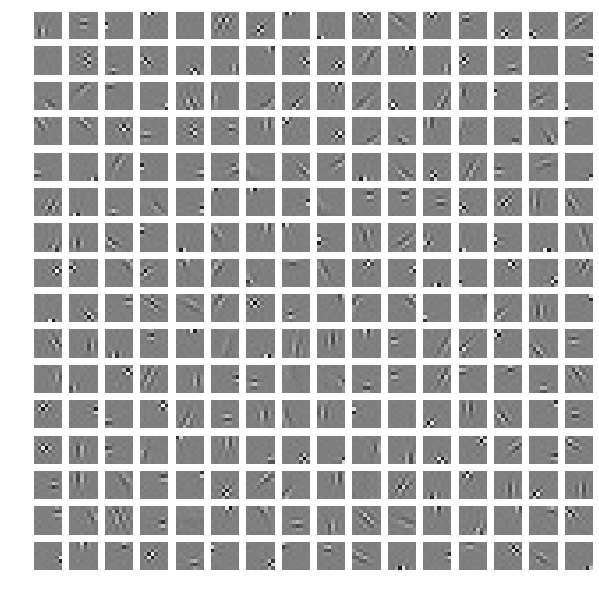

In [22]:
overcomplete_bases = overcomplete_ica.components_.dot(K)
plot_bases(overcomplete_bases,figsize=(10,10))

# The degeneracy problem in overcomplete ICA

In overcomplete ICA 

## Computing angles between feature vectors

A way to see how disimilar are these features is to compute the angle between them 


In [ ]:
def compute_angles(w):
    """Computes angle between pairs of vectors
    Parameters:
    ----------
    w: array
       ICA features. Dimension: n_costs X n_sources X n_dimensions
    """
    w = w/norm(w, axis=-1, keepdims=True)
    gram = w.dot(w.T)
    gram_off_diag = gram[np.tri(gram.shape[0], k=-1, dtype=bool)]
    return np.arccos(abs(gram_off_diag))/np.pi*180

In [ ]:
def plot_angles(angles,labels,density=True,figsize=None):
    """Plots angle distributions
    Parameters:
    ----------
    angles: array
           Set of angles obtained by training different ICA models on natural images.
           Dimension: n_costs X n_angles
    """
    if figsize is None:
        fig = plt.figure()
    else:
        fig = plt.figure(figsize=figsize)
    ax = plt.axes([.15,.1,.8,.8])
    col = np.linspace(0,1,len(labels))
    for i in xrange(len(labels)):
        h,b = np.histogram(angles[i],np.arange(0,91))
        if density:
             h= h/np.sum(h)
        b = np.arange(1,91)
        ax.plot(b,h,drawstyle='steps-pre',color=mpl.cm.viridis(col[i]),lw=1.5,label=labels[i])
    ax.set_yscale('log')
    if not density:
        ax.set_ylabel('Counts')
        ax.set_yticks([1e0,1e2,1e4])
    else:
        ax.set_ylabel('Density',labelpad=-10)
        ax.set_yticks([1e-5,1e0])
    ax.yaxis.set_minor_locator(mpl.ticker.NullLocator())
    ax.set_xlim(20,90)
    ax.legend(loc='best', frameon=False,ncol=1)
    #ax.set_xlabel(r'$\theta$',labelpad=0)
    ax.set_xlabel('Angle',labelpad=0)
    ax.set_xticks([20,55,90])
    plt.show()

In [ ]:
costs = ['L2','L4']
lambd = 10.
bases = learn_bases(X_pca, K, costs=costs, oc=oc,lambd=lambd)
n_sources = bases.shape[1]
angles = np.zeros((len(costs),(n_sources**2-n_sources)/2))
for i in xrange(len(costs)):
    angles[i] = compute_angles(bases[i])

In [ ]:
labels = [r'$L_2$',r'$L_4$']
plot_angles(angles,labels,density=True)

# Evaluating the diversity of learned features 

## Fitting Gabor functions to the bases

By fitting Gabor funtions to the learned features we obtain distributions of parameters that we can compare across methods


In [ ]:
params = get_Gabor_params(bases)

In [ ]:
vz.plot_GaborFit_xy(params[0][1],figsize=(5,5),color=.0)
vz.plot_GaborFit_xy(params[1][1],figsize=(5,5),color=.1)

In [ ]:
plot_GaborFit_polar(params[0][1],figsize=(6,6))
plot_GaborFit_polar(params[1][1],figsize=(6,6),color=0.)